In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [2]:
path = '../input/glioblastoma-radiosensitivity-dataset/glioblastoma_data/extracted_data/cell_behaviors/videos_transcriptions_csv'
print(path)

../input/glioblastoma-radiosensitivity-dataset/glioblastoma_data/extracted_data/cell_behaviors/videos_transcriptions_csv


In [3]:
def import_files(path):
    struc = pd.DataFrame(columns =["radiation_level", "path","code_file","group"])
    read = os.walk(path)
    for root, dirs, files in read:
        for name in files:
            if name.endswith(".csv"):
                #print(name)
                radiation = name.split("gy")
                [_,group,_] = name.split("_") 
                filepath = path+ '/' + name
                code_file = name[:-4] #removing suffix
                
                struc = struc.append({"radiation_level" : int(radiation[0]), "path" : filepath, "code_file" : code_file, "group" : group}, ignore_index=True)
                
    return struc

In [4]:
def str_to_numpy(input_str):
    """
    str_to_numpy is used to parse the columns "input" and "output" of the dataset csv files.
    It converts a string representing an array of cells to a numpy array containing strings
    which are the names of these cells.
    """
    process_str = input_str.replace("[", "")
    process_str = process_str.replace("'", "")
    process_str = process_str.replace(" ", "")
    process_str = process_str.replace("]", "")
    if(process_str != ""):
        process_str = process_str.split(",")
        output_array = np.asarray(process_str, dtype=str)
    else:
        output_array = np.asarray([], dtype=str)
    return output_array

In [5]:
file = path + "/0gy_n1_201104.nd2u2510Gy1A.csv"
data = pd.read_csv(file, converters = {"input" : str_to_numpy, "output" : str_to_numpy}) #imports a dataframe from a csv 
                  # and converts its string components to numpy
data.head()


,time,event,input,output
0,0,begin,[],[C1]
1,66,div,[C1],"[C1.1, C1.2]"
2,238,div,[C1.1],"[C1.1.1, C1.1.2]"
3,386,div,[C1.1.1],"[C1.1.1.1, C1.1.1.2]"
4,432,end,[C1.1.1.1],[]


## Algorithm :

We suppose that trees do not merge.

1. List begin events -> give us the root cells for each tree
2. Group together cells which contains the name of previous cells ("C1" and "C1.1" e.g.)
   1. Create a DataFrame with [root_cell, cell_name, time, event, input, ouput]

In [6]:
roots = data.loc[data.event == 'begin'].output
roots.head()

0     [C1]
16    [C2]
23    [C3]
39    [C4]
49    [C5]
Name: output, dtype: object

In [7]:
def root_cell_test(row, root): #Tests if the row corresponds to the root cell
    for c in row.input:
        if str(c).startswith(root):
            return True

    return False

def obtain_roots(experience):
    roots = experience.loc[experience.event == 'begin'].output 
    root_cells = []
    for cell in roots:
        root_cells.append(str(cell[0]))
    return(root_cells)

def cells_to_trees(experience): #experience is a DataFrame
    #Select root cells in experience
    root_cells = obtain_roots(experience) 

    #Creation of a tree corresponding to the experience
    trees = pd.DataFrame(columns = ["root_cell", "time","event","input","output"])
    frames = []
    for root in root_cells:
        #exp_bis = experience.loc[experience.event != "begin"]
        f = lambda row:root_cell_test(row, str(root))
        root_cell = experience[experience.apply(f, axis=1)]
        root_cell.insert(loc=0, column='root_cell', value=root, allow_duplicates=True)
        #trees = trees.append(root_cell)
        root_cell=root_cell.sort_values(by='time')
        trees = pd.concat([trees, root_cell], ignore_index=True, sort=False)
    return trees

In [8]:
#TEST 2
experience = pd.read_csv(file, converters = {"input" : str_to_numpy, "output" : str_to_numpy})
trees = cells_to_trees(experience)
trees[trees.event == "death"]

,root_cell,time,event,input,output
106,C8,293,death,[C8.3],[]


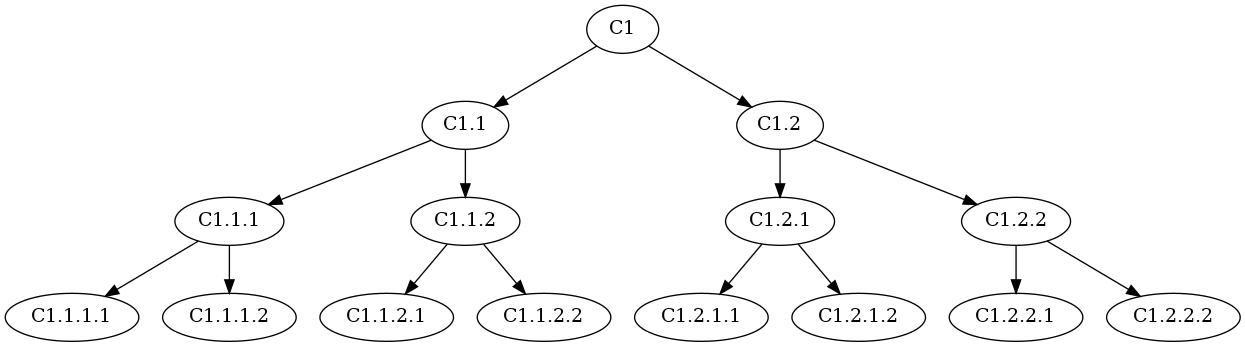

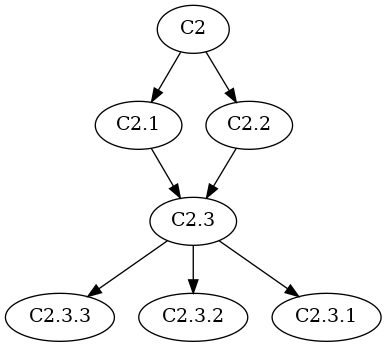

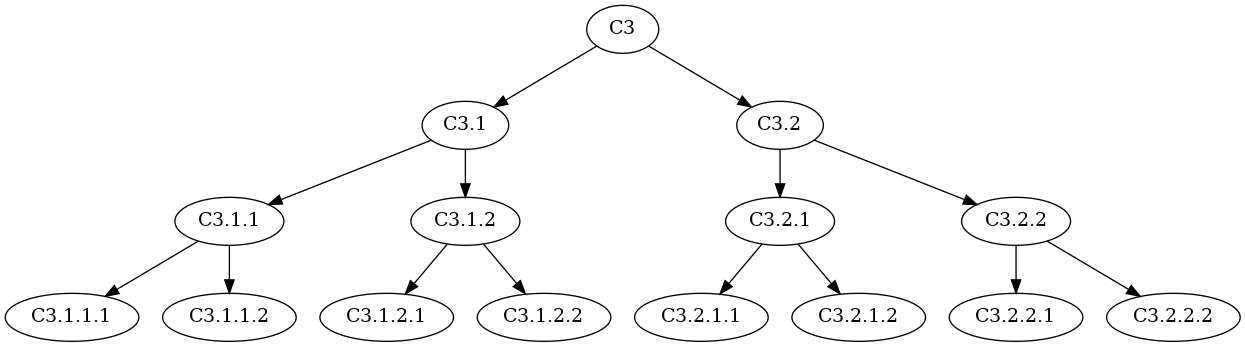

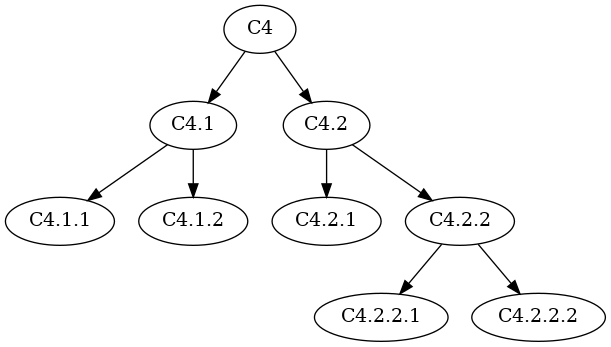

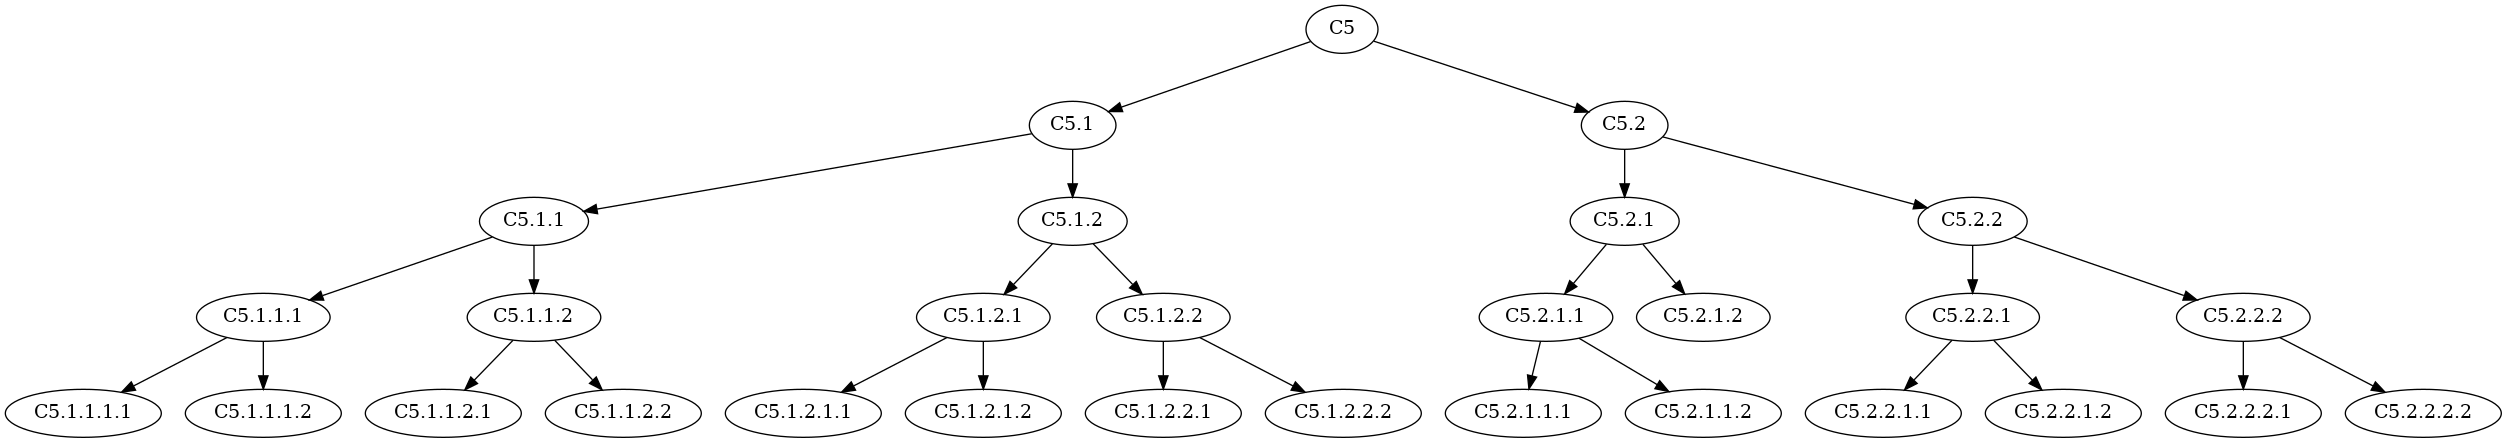

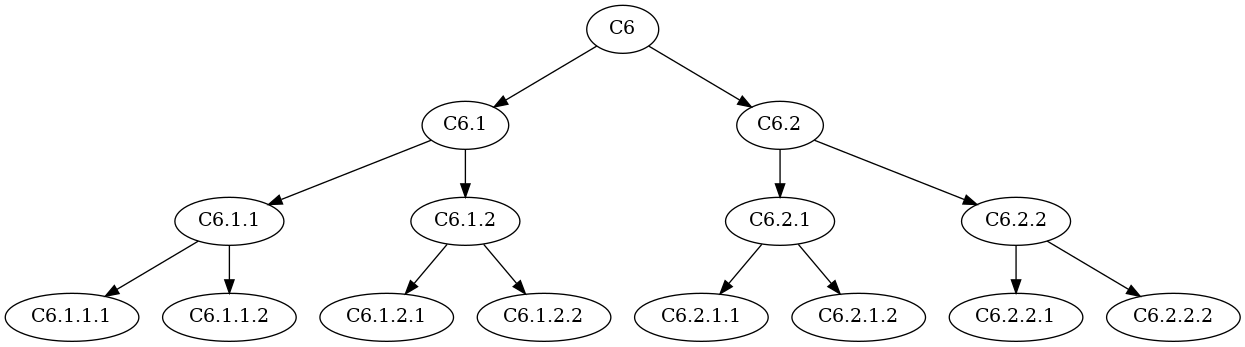

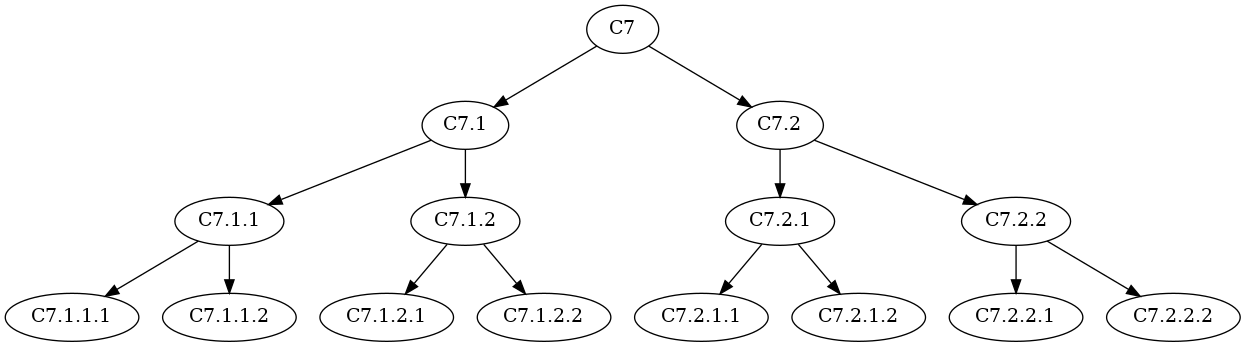

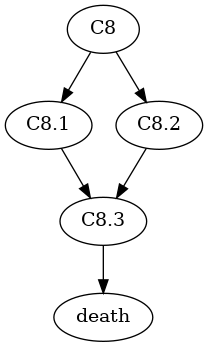

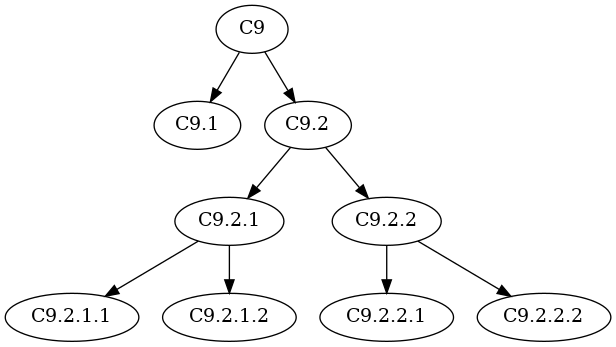

In [9]:
import pygraphviz as pgv
from IPython.display import Image, display

size_factor = 50;

def draw(dot):
    return display(Image(pgv.AGraph(dot).draw(format='png', prog='dot')))
    # return display(Image(pgv.AGraph(dot).draw(format='png', prog='neato'))) # with distance : not currently functionnal

def event_to_str(row, cell):
    dot_txt = cell + " [ pos = \"0,0!\" ]"
    if row.root_cell == cell:
        cell 
        for c_i in row.input:
            for c_o in row.output:
                dot_txt += c_o.replace(".", "") + " [ label = \"" +c_o+ "\", pos = \"0,"+str(-row.time/size_factor)+"!\"] \n"
                dot_txt +=  c_i.replace(".", "") + " -> " + c_o.replace(".", "") + "\n"
        if row.event == "death" :
            dot_txt += row.input[0].replace(".", "") + " -> death \n"
        # if row.event == "end" :
        #     str += row.input[0].replace(".", "") + " -> alive \n" # Don't give a great looking result.
                
    return dot_txt

graphs = []
for c in obtain_roots(experience) :
    g = lambda row : event_to_str(row, c)

    t = trees.apply(g, axis=1)
    graph = "digraph top {"
    for row in t:
        if row!="" :
            graph += row
    graph += "}"
    graphs.append(graph)

for graph in graphs:
    draw(graph)

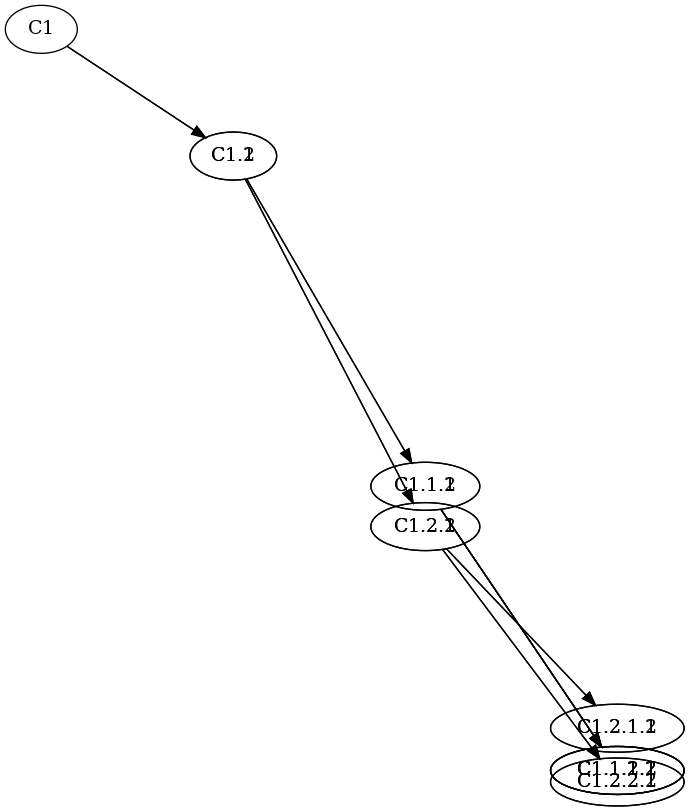

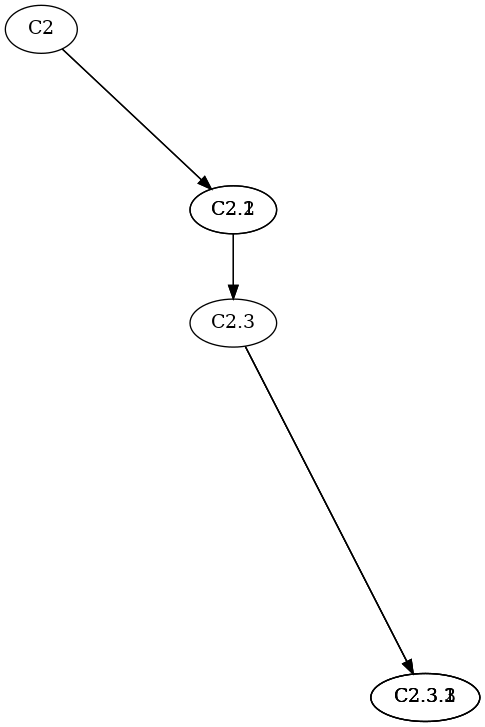

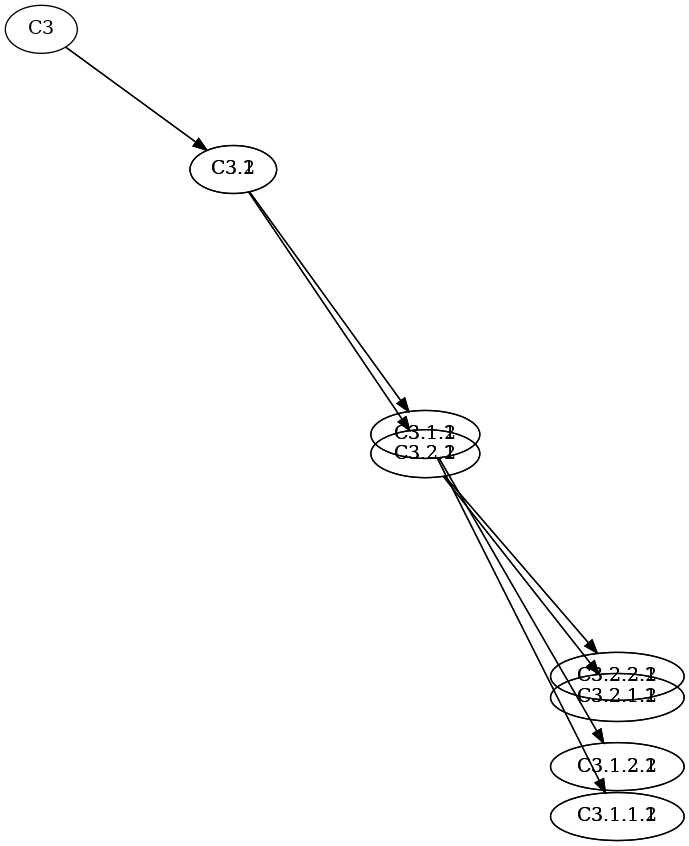

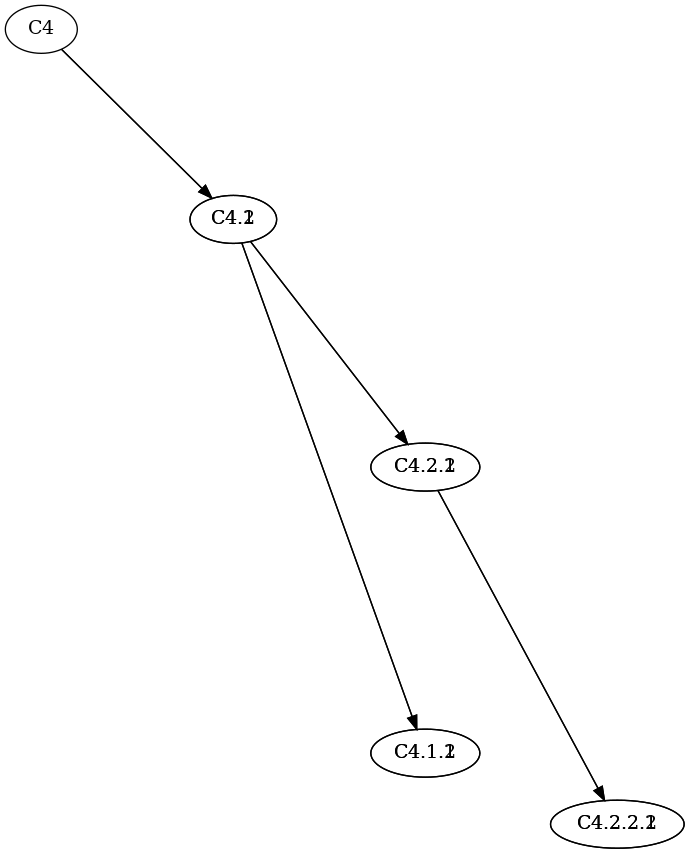

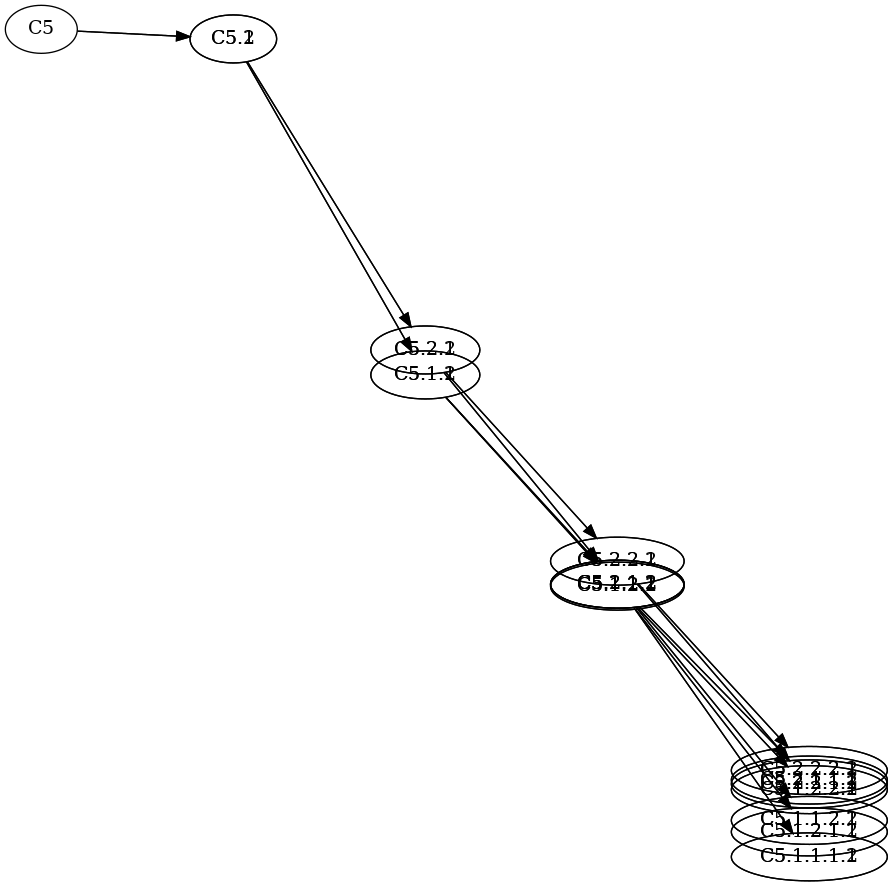

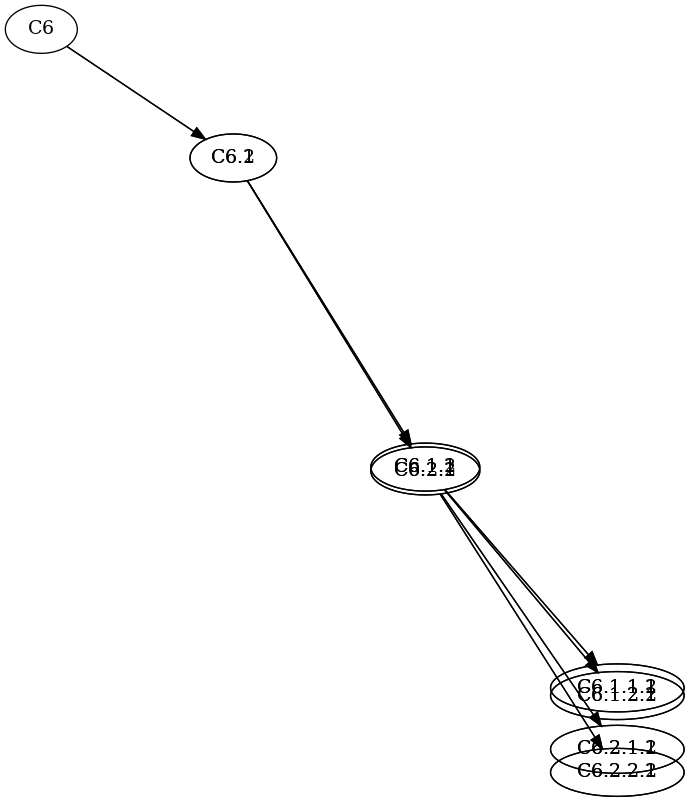

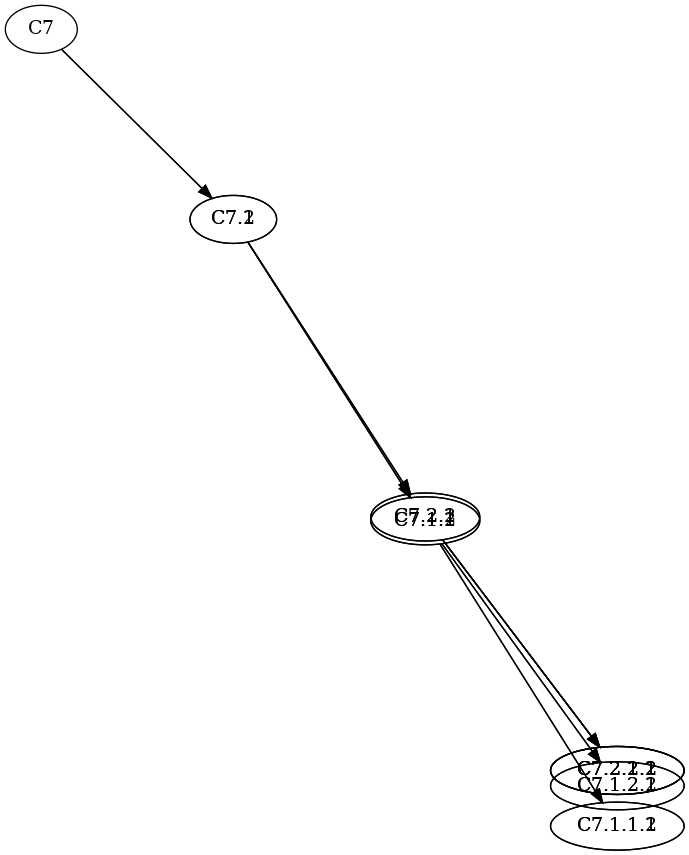

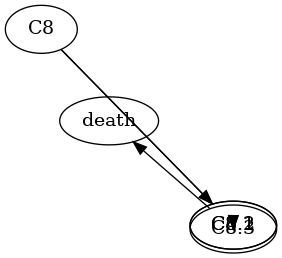

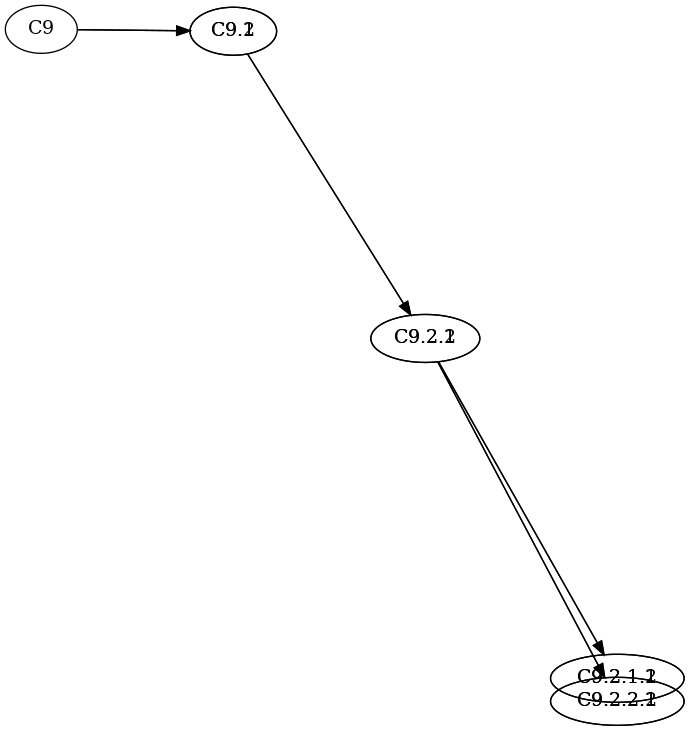

In [10]:
import pygraphviz as pgv
from IPython.display import Image, display

size_factor = 50;

def draw(dot):
    return display(Image(pgv.AGraph(dot).draw(format='png', prog='neato')))
    # return display(Image(pgv.AGraph(dot).draw(format='png', prog='neato'))) # with distance : not currently functionnal

def event_to_str(row, cell):
    dot_txt = cell + " [ pos = \"0,0!\" ]"
    if row.root_cell == cell:
        cell 
        for c_i in row.input:
            for c_o in row.output:
                pos_x_o = (len(c_o)/2 -1)*2
                dot_txt += c_o.replace(".", "") + " [ label = \"" +c_o+ "\", pos = \""+str(pos_x_o)+","+str(-row.time/size_factor)+"!\"] \n"
                dot_txt +=  c_i.replace(".", "") + " -> " + c_o.replace(".", "") + "\n"
        if row.event == "death" :
            dot_txt += row.input[0].replace(".", "") + " -> death \n"
        # if row.event == "end" :
        #     str += row.input[0].replace(".", "") + " -> alive \n" # Don't give a great looking result.
                
    return dot_txt

graphs = []
for c in obtain_roots(experience) :
    g = lambda row : event_to_str(row, c)

    t = trees.apply(g, axis=1)
    graph = "digraph top {"
    for row in t:
        if row!="" :
            graph += row
    graph += "}"
    graphs.append(graph)

for graph in graphs:
    draw(graph)

Computing tree of root cell C1
change of last_time :66
change of last_time :238
change of last_time :364


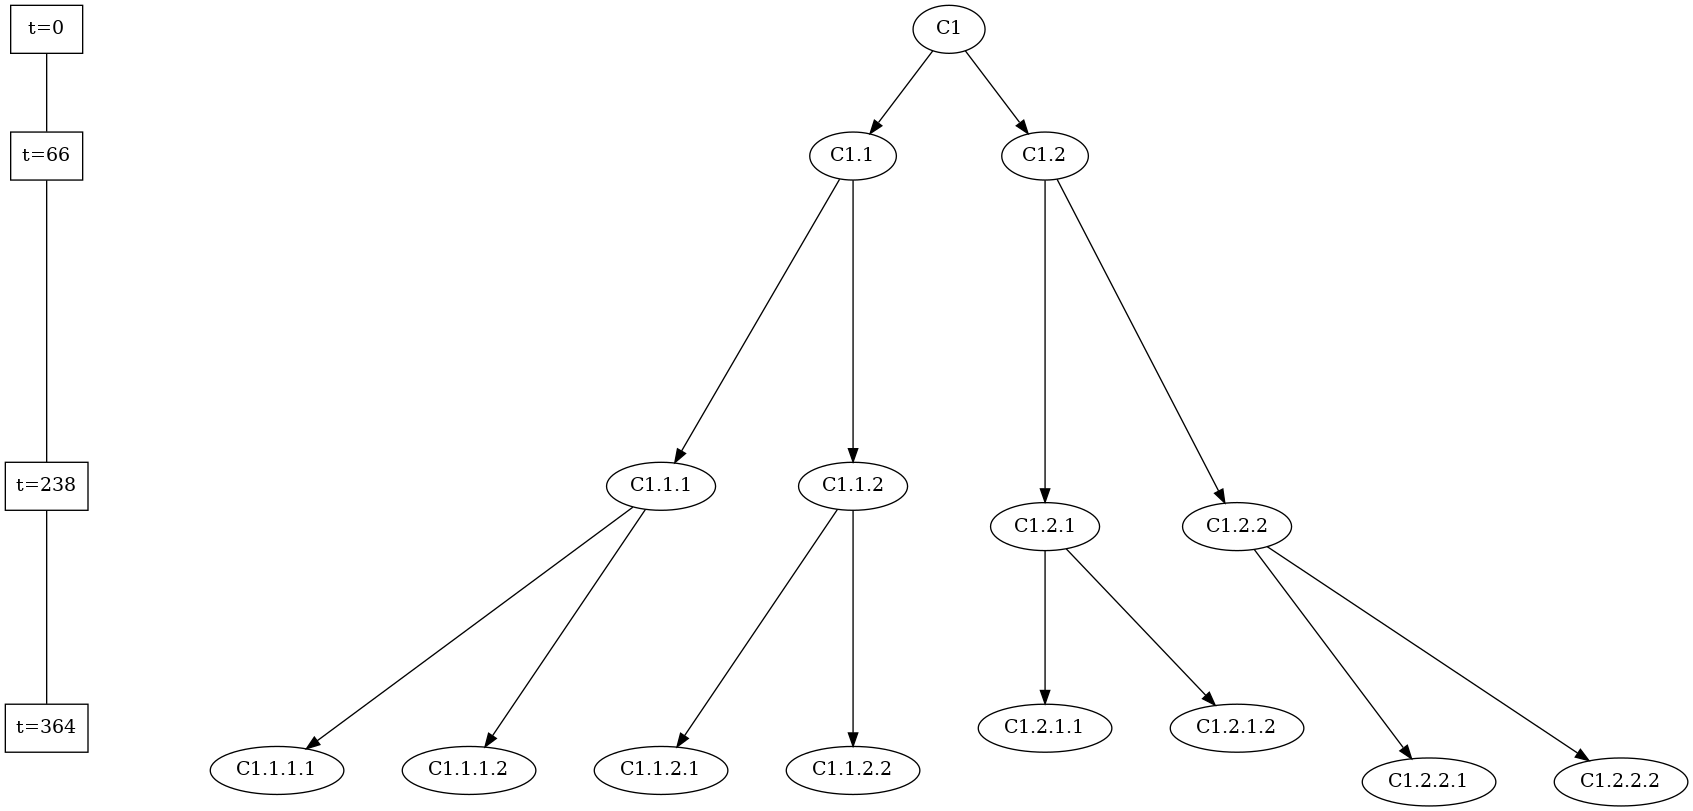

Computing tree of root cell C2
change of last_time :94
change of last_time :153
change of last_time :348


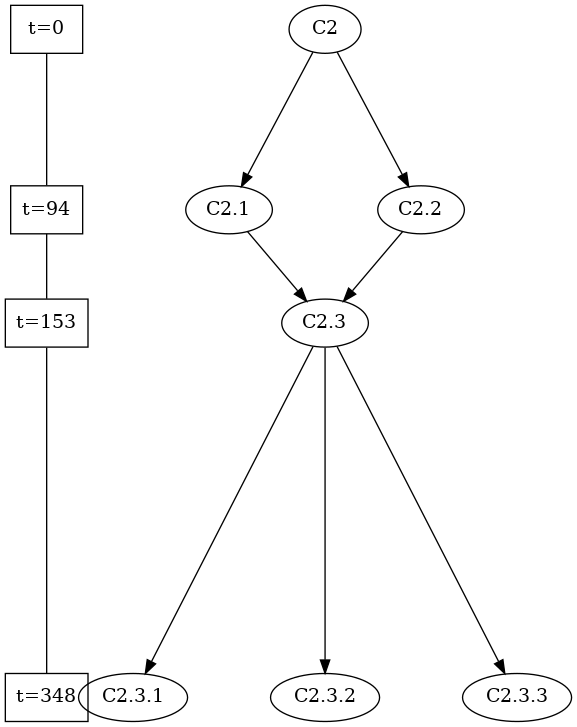

Computing tree of root cell C3
change of last_time :73
change of last_time :211
change of last_time :337


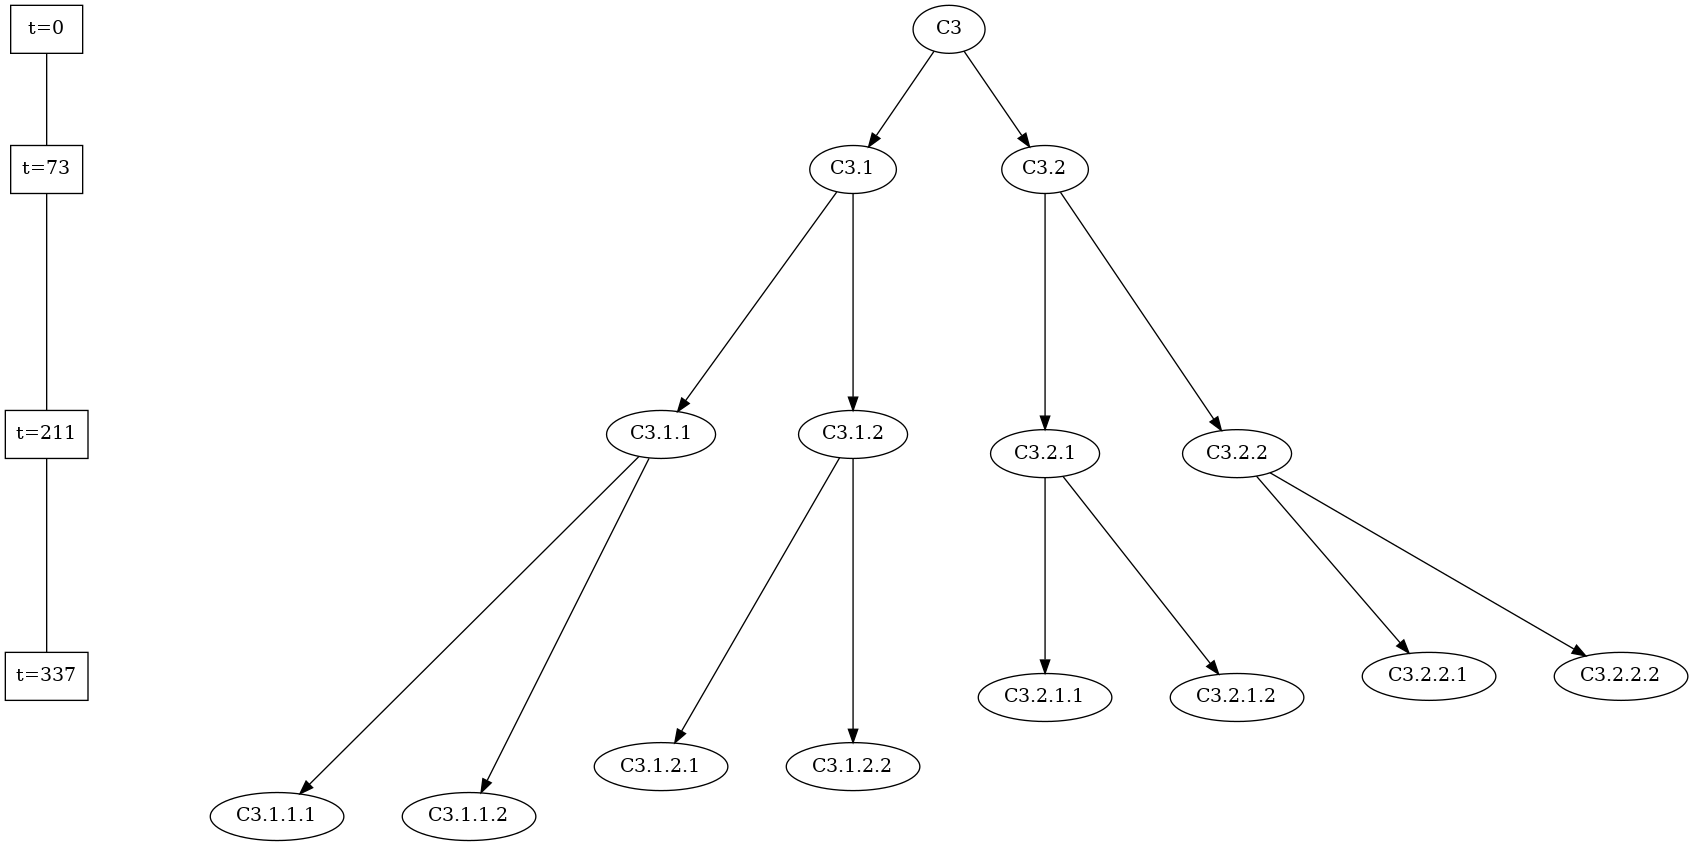

Computing tree of root cell C4
change of last_time :99
change of last_time :228
change of last_time :377


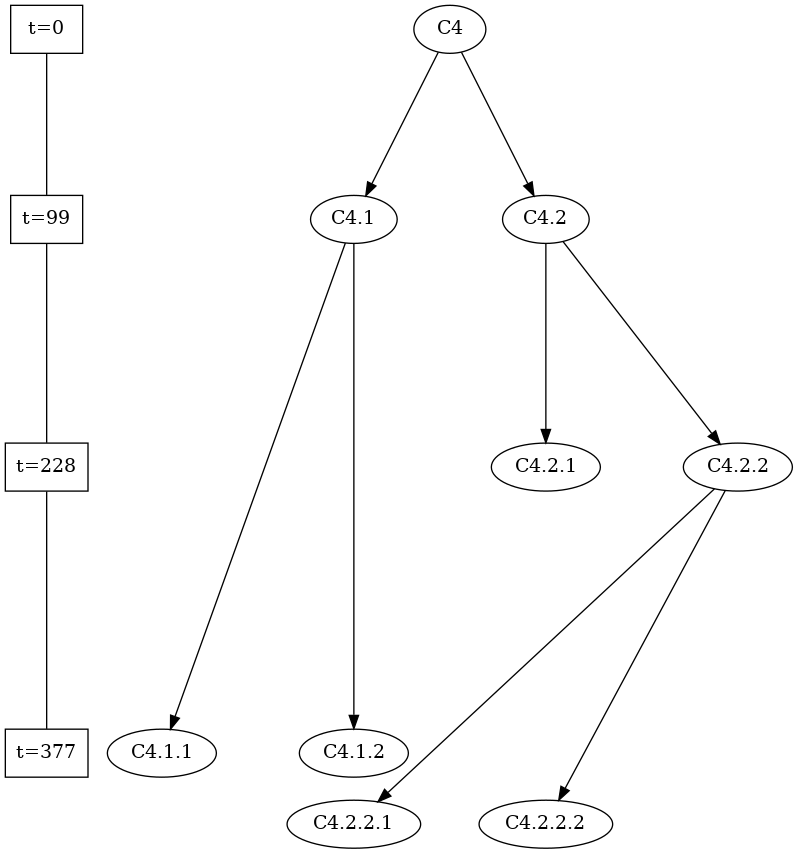

Computing tree of root cell C5
change of last_time :167
change of last_time :277
change of last_time :386


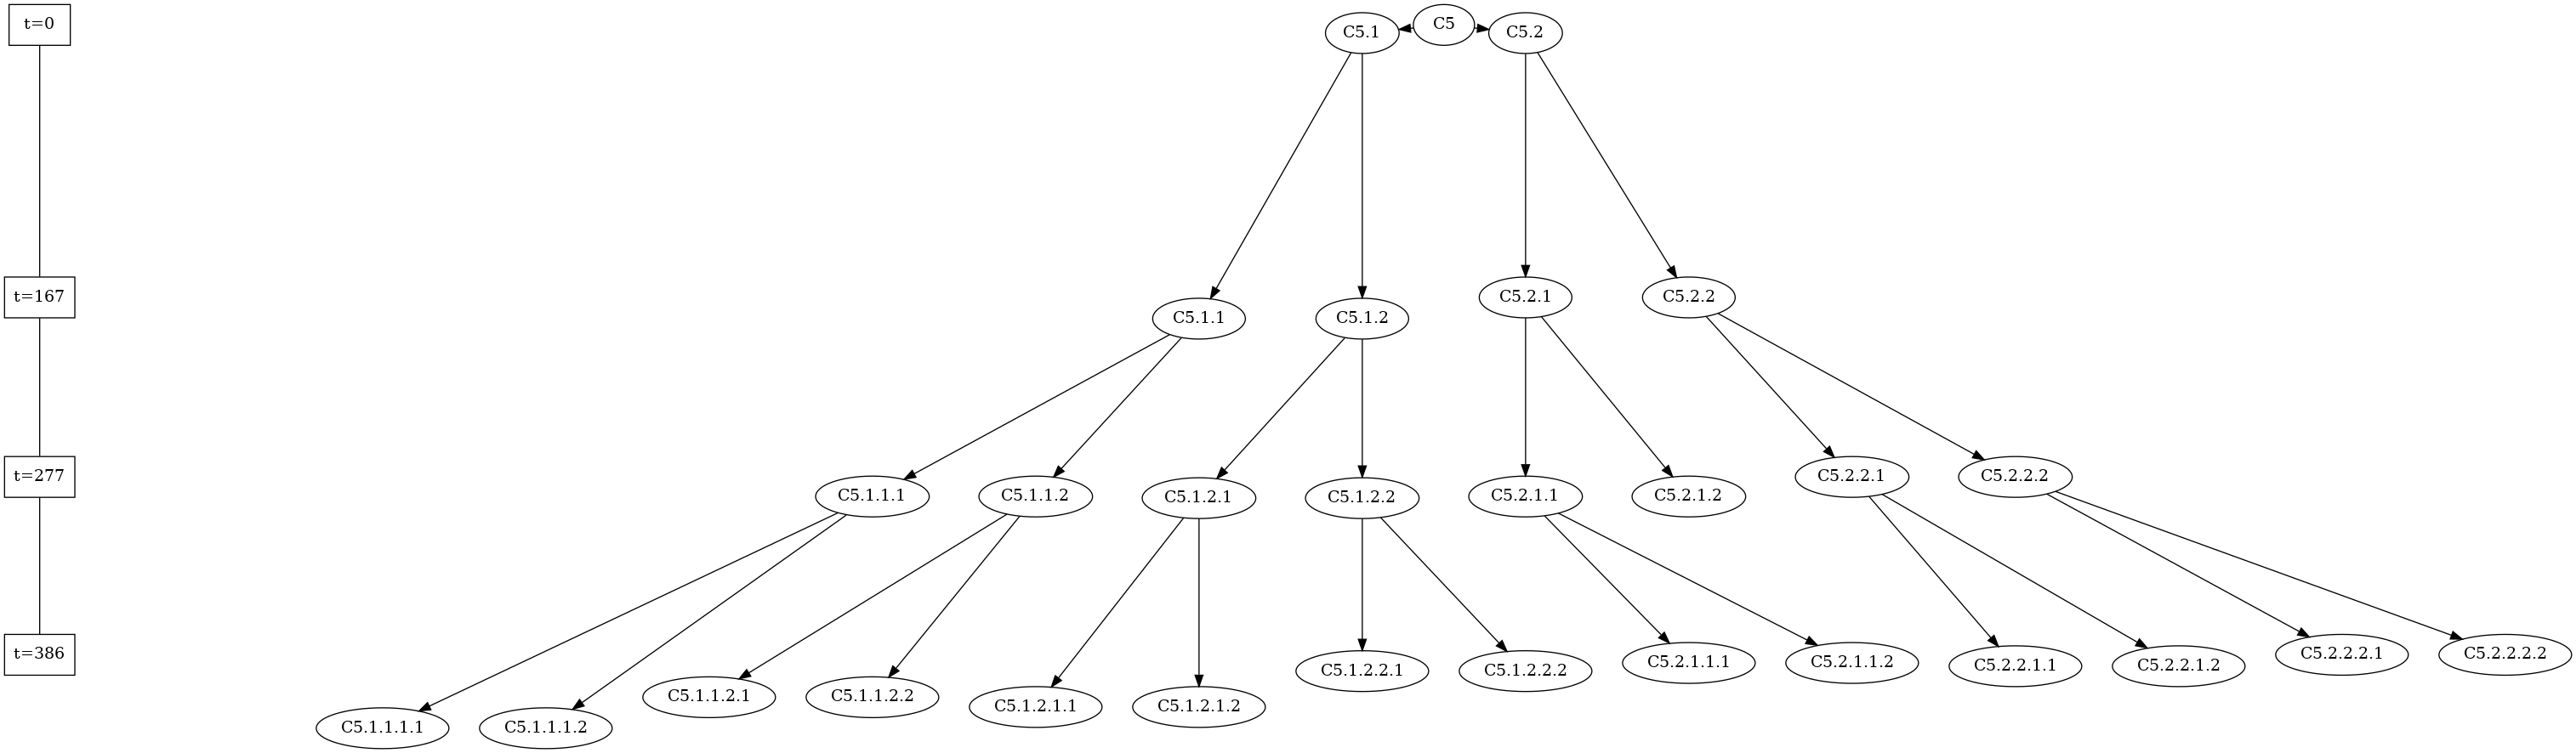

Computing tree of root cell C6
change of last_time :67
change of last_time :228
change of last_time :343


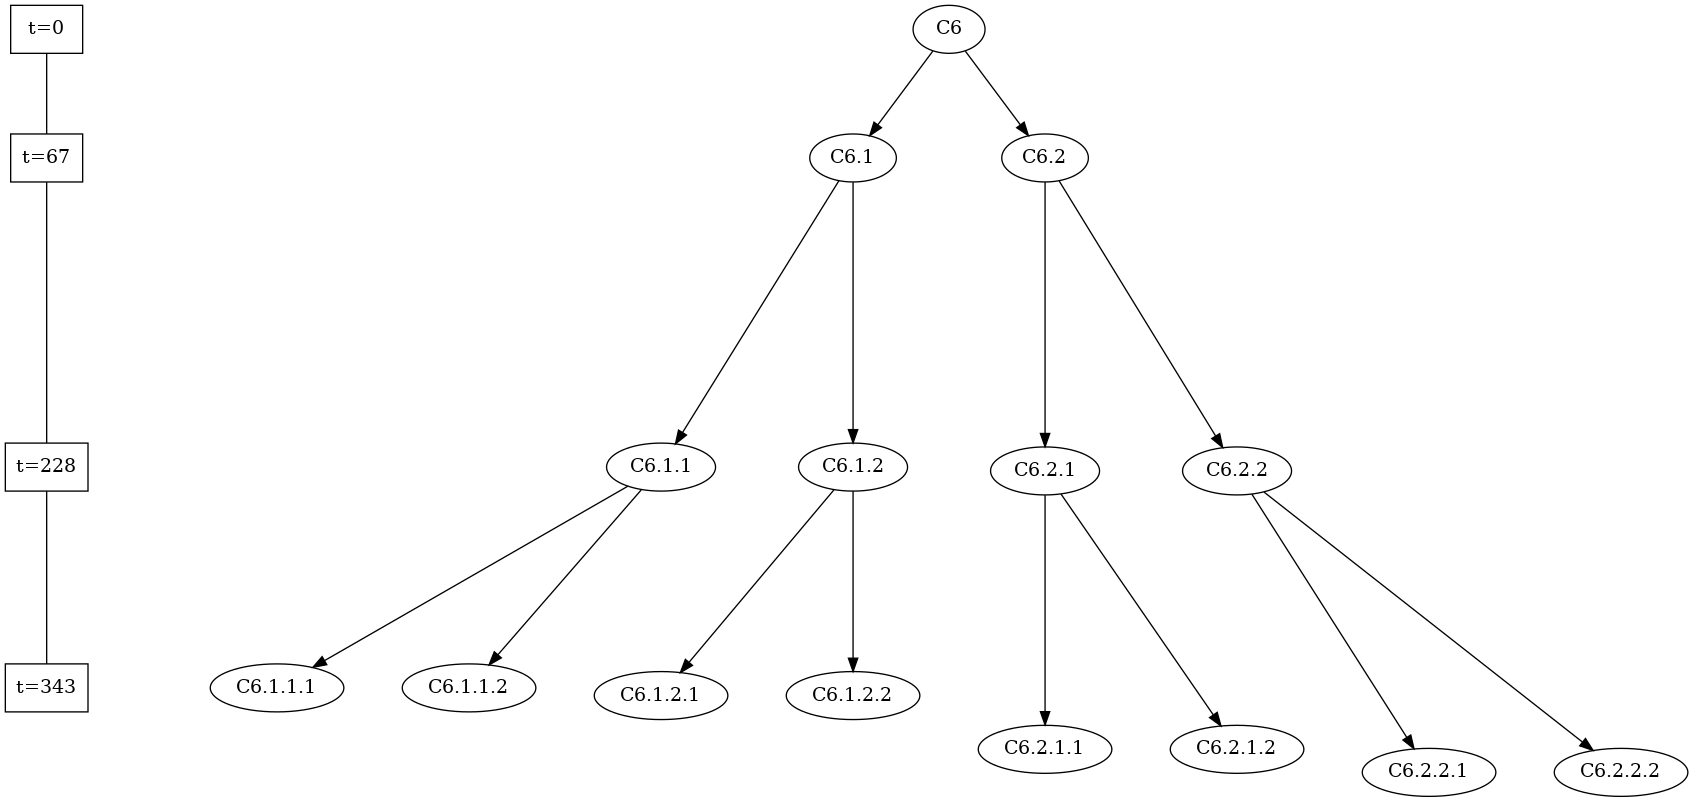

Computing tree of root cell C7
change of last_time :99
change of last_time :254
change of last_time :386


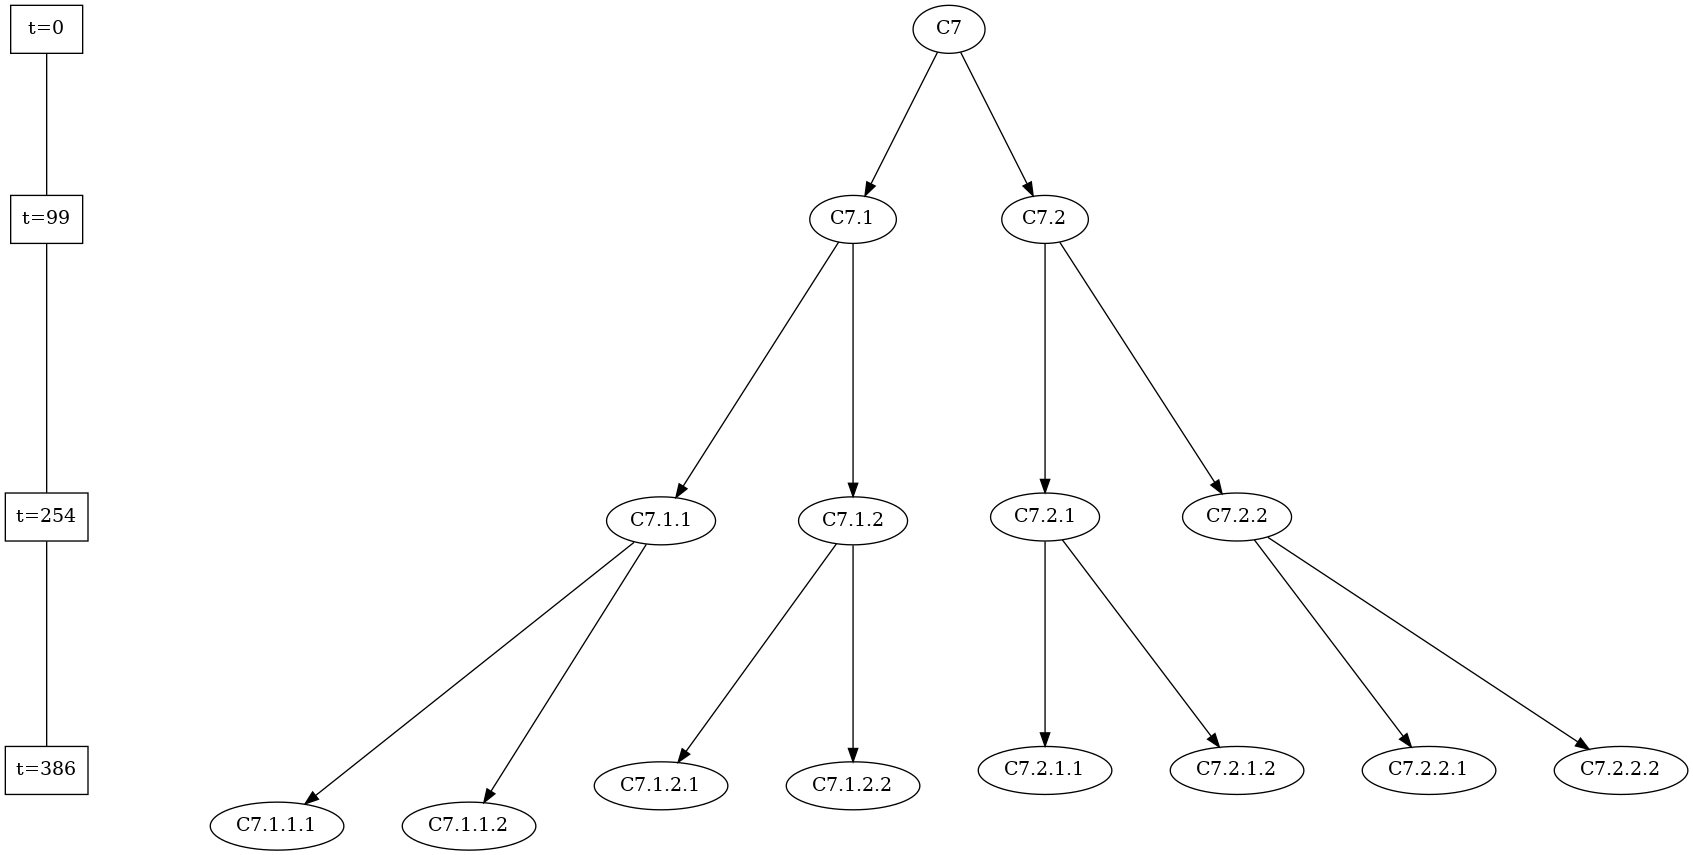

Computing tree of root cell C8
change of last_time :102


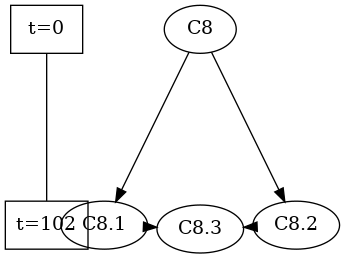

Computing tree of root cell C9
change of last_time :161
change of last_time :338


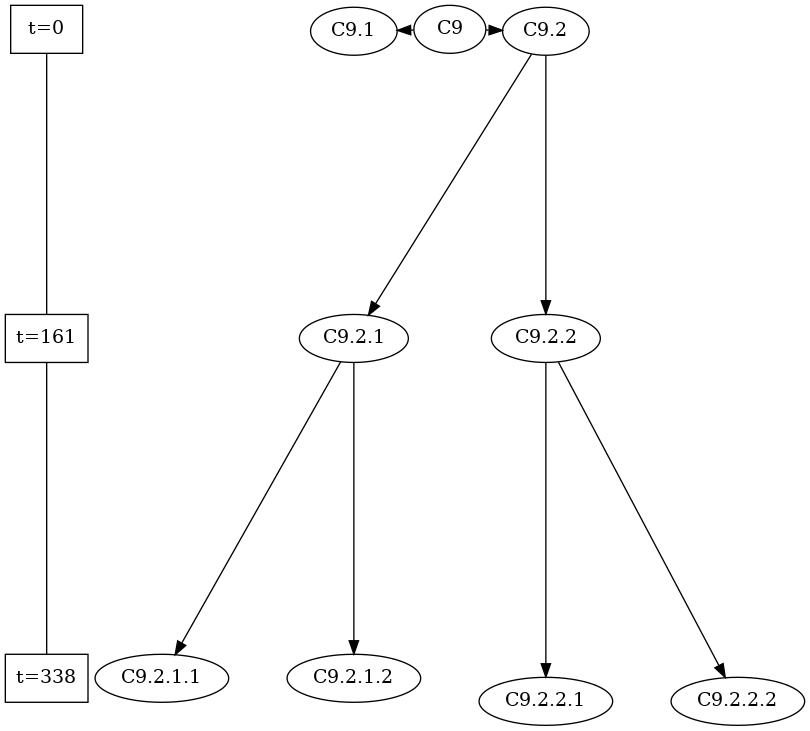

In [26]:
#need to be refactor : some argument are missing => using global values...

import pygraphviz as pgv
from IPython.display import Image, display

size_factor = 50;

def draw(dot):
    return display(Image(pgv.AGraph(dot).draw(format='png', prog='neato')))
    # return display(Image(pgv.AGraph(dot).draw(format='png', prog='neato'))) # with distance : not currently functionnal

def list_nodes(tree):
    l = []
    for row in tree.itertuples() :
        for c_i in row.input:
            if not c_i in l:
                l.append(c_i)
        for c_o in row.output:
            if not c_o in l:
                l.append(c_o)
    return l

def adjacency_matrix(tree):
    m = np.zeros((size_graph, size_graph), dtype=int)
    for row in tree.itertuples():
        for c_i in row.input:
            for c_o in row.output:
                index_i = nodes.index(c_i)
                index_o = nodes.index(c_o)
                m[index_i, index_o] = row.time
    return m

def l2_dist(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)


def conflict(positions_dict, pos, gap):
    for _, p in positions_dict.items():
        if l2_dist(pos, p) <= gap :
            return True
    return False


def distance_to_root(adj_matrix, node_idx):
    graph = adj_matrix
    for i in range(size_graph):
        if graph[0, node_idx] != 0:
            return i+1
        graph = graph.dot(adj_matrix)
    return -1


def levels(adj_matrix, nodes, size_graph):
    list_of_levels = {}
    list_of_levels[0] = [nodes[0]]
    for i in range(1,size_graph):
        level = distance_to_root(adj_matrix, i)
        if level in list_of_levels:
            list_of_levels[level].append(nodes[i])
        else :
            list_of_levels[level] = [nodes[i]]

    return list_of_levels
        

def max_gap(positions_dict):
    gap = 0
    for _, p1 in positions_dict.items():
        for _, p2 in positions_dict.items():
            dist = l2_dist(p1, p2)
            if dist > gap :
                gap = dist
    return gap


def size_x_max(dict):
    return max([len(level) for _, level in dict.items()])


def labels_and_pos(adj_matrix, factor_y, factor_x, offset_x):
    list_of_levels = levels(adj_matrix, nodes, size_graph)
    size_x = size_x_max(list_of_levels)

    times = [0]

    labels_str = ""

    positions_dict = {}
    positions_dict[nodes[0]] = [0,0]

    # Compute y positions of the cells.
    for i in range(size_graph):
        for j in range(size_graph):
            if adj_matrix[i, j] > 0:
                y = -adj_matrix[i,j]/factor_y
                pos = [0, y]
                if not adj_matrix[i,j] in times :
                    times.append(adj_matrix[i,j])
                positions_dict[nodes[j]] = pos
    times.sort()

    # Add time axis.
    labels_str += str(times[0])+" [ label = \"t=" +str(times[0])+"\" , pos = \"0,0!\" , shape = box ] \n"
    last_time = times[0]
    for i in range(len(times)-1) :
        t1 = times[i]
        t2 = times[i+1]
        # Test conflict on time labels.
        if(l2_dist([0,-t2/factor_y], [0,-t1/factor_y]) > 1):
            labels_str += str(t2)+ " [ label = \"t="+str(t2)+"\" , pos = \"0,"+str(-t2/factor_y)+"!\" , shape = box ] \n"
            labels_str += str(last_time)+" -> "+str(t2)+" [ arrowhead = none , arrowtaile = none ] \n"
            last_time = t2
            print("change of last_time :" + str(last_time))
        

    # Compute x positions of the cells.
    for _, level in list_of_levels.items():
        level.sort()
        size_level = len(level)
        size = factor_x*size_level
        step = size/size_level
        pos_x = [offset_x*size_x -size/2 + step*i for i in range(size_level)]
        for i in range(len(level)):
            node = level[i]
            pos = positions_dict[node]
            pos[0] = pos_x[i]
            labels_str += node.replace(".", "") +" [ label = \""+node+"\" , pos = \""+str(pos[0])+","+str(pos[1])+"!\" ] \n"

    return labels_str


def links(adj_matrix):
    links_str = ""
    for i in range(size_graph):
        for j in range(size_graph):
            if adj_matrix[i, j] > 0:
                links_str += nodes[i].replace(".", "") + " -> " + nodes[j].replace(".", "") + " \n"
    return links_str

for cell in obtain_roots(experience) : 
    tree_1 = trees[trees["root_cell"] == cell]
    print("Computing tree of root cell " + cell)
    nodes = list_nodes(tree_1)
    size_graph = len(nodes)
    m = adjacency_matrix(tree_1)
    graph = "digraph top { \n" + links(m) + labels_and_pos(m, 50, 2, 1.3) + "}"
    #print(graph)
    draw(graph)


In [52]:
levels(m, nodes, size_graph)

{0: ['C1'],
 1: ['C1.1', 'C1.2'],
 2: ['C1.1.1', 'C1.1.2', 'C1.2.1', 'C1.2.2'],
 3: ['C1.2.1.1',
  'C1.2.1.2',
  'C1.1.1.1',
  'C1.1.1.2',
  'C1.1.2.1',
  'C1.1.2.2',
  'C1.2.2.1',
  'C1.2.2.2']}

In [12]:
def list_of_trees(data_frame):
    trees_list = pd.DataFrame(columns =["tree_id", "tree"])
    for idx in data_frame.index:

        #Select experience correspondingto index idx
        path = data_frame.loc[idx,'path']
        file_name = data_frame.loc[idx,'code_file']
        file_path = path + "/"+ file_name + ".csv"
        experience = pd.read_csv(file_path, converters = {"input" : str_to_numpy, "output" : str_to_numpy})

        trees = cells_to_trees(experience)
        
        #Add experience trees to the list of all trees
        trees_list.append({"tree_id" : "pouet"})